## TSNE
T-SNE treats dimensionality reduction as an optimization problem. 

We know how to compute the pairwise distances between points in high dimensional space (these pairwise distances are computed once, since we do not nudge high dim points). We also know how to compute pairwise distances between points in low dimensional space. 

We can compare these two pairwise distances (using something like KL divergence). By computing gradients, we can nudge points in low dim space in order to minimize KL divergence between those pairwise distances.

https://observablehq.com/@nstrayer/t-sne-explained-in-plain-javascript

In [79]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

def gaussian_prob(i, j, sigma):
    """Compute p(dist(j, i)) using N(0, sigma).
    """
    dist = np.linalg.norm(np.array(i) - np.array(j))
    unnormalized_prob = scipy.stats.norm(0, sigma).pdf(dist)
    return unnormalized_prob


def compute_asymmetric_probs(ls_pts):
    """Compute pairwise distances for list of points.
    """
    var = 1
    # each row represents p_ij where point i is the anchor point
    asymmetric_matrix = []
    
    # find p_ij for all possible anchor points i
    for ix in range(len(ls_pts)):
        
        # list of probabilities according to a perplexity target
        ls_pij = find_best_normalized_probs_given_i(ix, ls_pts)
        
        # once we've found a list of probs_ij that satisfy a target perplexity, keep it
        asymmetric_matrix.append(ls_pij)
    return np.array(asymmetric_matrix)


def find_best_normalized_probs_given_i(ix, ls_pts):
    """Return a list of normalized probabilities of seeing Js given anchor I.
    """
    target_perplexity = 3
    sigma = 0.1
    ls_probs = _compute_normalized_probs_given_i(ix, ls_pts, sigma)
    perplexity = _calculate_perplexity(ls_probs)
    
    # increment sigma until we reach desired level of perplexity
    while perplexity < target_perplexity:
        sigma += 0.1
        ls_probs = _compute_normalized_probs_given_i(ix, ls_pts, sigma)
        perplexity = _calculate_perplexity(ls_probs)
    
    # return the list of probabilities of seeing all points J given point I, subject to desired perplexity
    return ls_probs


def _compute_normalized_probs_given_i(ix, ls_pts, sigma):
    """Return a list of normalized probabilities of seeing Js given anchor I.
    """
    # compute probabilities of J's given anchor I
    ls_normalized_probs = []
    for jx in range(len(ls_pts)):
        if jx == ix:  
            ls_normalized_probs.append(0)  # ignore probability of seeing point I given anchor point I
        else:
            # probability of seeing J given anchor I
            prob = _compute_prob_ij(ix, jx, sigma, ls_pts)  
            ls_normalized_probs.append(prob)
    return ls_normalized_probs


def _compute_prob_ij(ix, jx, sigma, ls_pts):
    """Compute the normalized probability of seeing J given I.
    
    We normalized by dividing the unnormalized p(J|I) by the sum of all 
    p(J|I).
    """
    pt_i = ls_pts[ix]  # anchor point I
    pt_j = ls_pts[jx]  # target point J
    numerator = gaussian_prob(pt_i, pt_j, sigma)
    
    # calculate sum of probabilites so we can normalize
    denominator = 0
    for kx in range(len(ls_pts)):
        if kx != ix:
            pt_k = ls_pts[kx]
            denominator += gaussian_prob(pt_i, pt_k, sigma)
    return np.round(numerator / denominator, 2)


def calc_fake_probs(i_idx, low_d_points):
    """Compute probabilities of seeing Js given anchor I in low dimensional space.
    """
    fake_probs = []
    
    for j_idx in range(len(low_d_points)):
        if j_idx == i_idx:
            fake_probs.append(0)
        else:
            i = low_d_points[i_idx]
            j = low_d_points[j_idx]
            
            # first, compute numerator between i and j
            numerator = 1 / (1 + (np.linalg.norm(i - j) ** 2))

            # then, compute denominator, which is the sum of probabilities
            denominator = 0
            for k_idx in range(len(low_d_points)):
                if k_idx != i_idx:
                    k = low_d_points[k_idx]
                    d = 1 / (1 + (np.linalg.norm(i - k) ** 2))
                    denominator += d
            
            fake_prob = numerator / denominator  # prob(j | i)
            fake_probs.append(fake_prob)
    return fake_probs


def a2s(am):
    """Convert an asymmetric matrix am to a symmetric one.

    We do this with prob(ij) = np.average(prob(i|j), prob(j|i)).
    """
    n_points = len(am[0])
    
    # preallocate an empty matrix
    sm = np.zeros(shape=(n_points, n_points))
    
    # update each element
    for i in range(n_points):
        for j in range(n_points):
            sm[i][j] = np.average((am[i][j], am[j][i]))
    return sm


def _calculate_perplexity(ls_probs):
    """Compute perplexity for a list of points J given anchor point I.
    
    By increasing perplexity, we widen the probability curve so it is more
    likely to see J given anchor I.
    """
    # remove probability of seeing point I given an anchor point I
    ls_probs = [p for p in ls_probs if p!= 0]
    
    # calculate entropy
    entropy = np.sum([-p*(np.log(p)) for p in ls_probs])
    
    # calculate perplexity
    perplexity = 2 ** entropy
    return perplexity

## Step 1
Generate points in high dimensional space.

In [74]:
# generate real points
high_dim_pts = [[-1.7, -2.1, -3.1], 
                [-0.5, -1.0, -1.3], 
                [-3.1, -2.2, -1.0], 
                [2.2, 2.1, 1.6],
                [1.3, 1.1, 1.1], 
                [0.5, 1.1, 1.3]]
n_points = len(high_dim_pts)
np.array(high_dim_pts)

array([[-1.7, -2.1, -3.1],
       [-0.5, -1. , -1.3],
       [-3.1, -2.2, -1. ],
       [ 2.2,  2.1,  1.6],
       [ 1.3,  1.1,  1.1],
       [ 0.5,  1.1,  1.3]])

## Step 2
Compute pairwise distances between each point in high dimensional space. 

The trick is to compute distance D between points I and J as `p(D | N(0, sigma)`. That is, what is the probability of seeing a distance D using a normal distribution?

If want to increase the probability of seeing Js given I, we can widen the distribution by increasing targeted perplexity.

In [75]:
# generate pairwise distances for points in high dim space
am1 = compute_asymmetric_probs(high_dim_pts)
sm1 = a2s(am1)
sm1

array([[0.   , 0.255, 0.255, 0.145, 0.16 , 0.16 ],
       [0.255, 0.   , 0.24 , 0.165, 0.2  , 0.205],
       [0.255, 0.24 , 0.   , 0.145, 0.16 , 0.175],
       [0.145, 0.165, 0.145, 0.   , 0.255, 0.245],
       [0.16 , 0.2  , 0.16 , 0.255, 0.   , 0.25 ],
       [0.16 , 0.205, 0.175, 0.245, 0.25 , 0.   ]])

## Step 3
Randomly generate fake points in low dimensional space.

In [76]:
# generate fake points - these points will be updated via gradient descent
low_dim = 2  # desired dimensionality of mapping
low_dim_pts = np.random.uniform(low=-1.0, high=1.0, size=(n_points, low_dim))
low_dim_pts

array([[ 0.29424012, -0.66937256],
       [ 0.74468261, -0.70407362],
       [ 0.98420972,  0.70779546],
       [-0.39558945,  0.05011148],
       [-0.48878932,  0.33486924],
       [-0.0562762 ,  0.02653853]])

## Step 4: Gradient Descent
We compute the gradient for the distance between the two sets of pairwise distances (ie the distance between the high dim pairwise matrix and low dim pairwise matrix), and use it to nudge points in low dimensional space.

This [KD derivative is specific to T-SNEs](https://stats.stackexchange.com/questions/276607/deriving-the-gradient-of-the-loss-in-sne), since T-SNE computes probability distributions in a specific way. That means you cannot use this KL derivative to compare two other matrices.

In [77]:
n_epochs = 1000
step_size = 0.01

for epoch in range(n_epochs):
    
    # nudge each point in low dim space by treating it as the anchor point
    for i in range(n_points):

        # a fake prob is the probability of seeing point J given anchor point I in low dimensional space
        ls_fake_probs = calc_fake_probs(i, low_dim_pts)  
        
        # compute gradient for all possible j's
        acc_grad = 0
        for j in range(n_points):
            if j != i:
                t1 = sm1[i][j] - ls_fake_probs[j]
                t2 = low_dim_pts[i] - low_dim_pts[j]
                dist = np.linalg.norm(t2)
                t3 = 1 / (1 + (dist ** 2))
                grad = t1 * t2 * t3
                acc_grad += grad

        # update anchor point i with gradient descent
        low_dim_pts[i] = low_dim_pts[i] - (step_size * acc_grad)

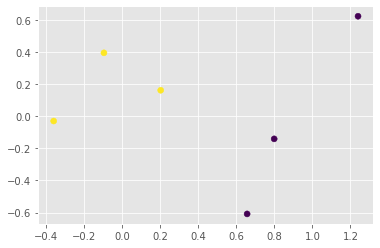

In [80]:
plt.scatter(low_dim_pts[:,0], low_dim_pts[:,1], c=[0,0,0,1,1,1])